<a href="https://colab.research.google.com/github/SaberaTalukder/Chen_Institute_DataSAI_for_Neuroscience/blob/main/07_11_22_day5_single_cell_and_hypothesis_testing/code/diy_notebooks/regressionColabExercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Regression Modeling for Single-cell Data**

For this set of exercises we will be applying linear and logistic regression techniques to model and predict features of interest across cells, assess the assumptions of these methods, and to implement a partial correlation analysis.

In [ ]:
#To run a code cell, select the cell and hit Command/Ctrl+Enter or click the run/play symbol
#Click Insert --> Code Cell or the '+ Code' option to insert a new code cell

In [ ]:
#Click Insert --> Text Cell or the '+ Text' option to insert a cell for text as below

In [ ]:
# This is  used to time the running of the notebook
import time
start_time = time.time()

Text here for descriptions, explanations, etc

##**Import data and install packages**

In [ ]:
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt #Can use other plotting packages like seaborn

In [ ]:
# ! allows you to run commands in the command line, as you would in your normal terminal/command line interface

In [ ]:
#Download count matrix of cell by gene counts
#Cells are 10x sequenced mouse primary cortex cells (...)

!wget --content-disposition https://data.caltech.edu/tindfiles/serve/2a3c58f3-dde2-4a46-9497-eaf6a4f9c3fc/

In [ ]:
#Gunzip the files we downloaded
!tar -xf *.gz

## **Read in data for analysis**

**The dataset**

We will be working with 10x Genomics sequencing data from the mouse primary cortex, produced by the BRAIN Initiative Cell Census Network (BICCN) [(Yao et al. 2021)](https://www.nature.com/articles/s41586-021-03500-8). They assayed 94,162 cells by 10x sequencing (as well as SMART-seq), though we will work with only a subsetted sample today.  The cell type labels include GABAergic and Glutamatergic cells as well as Non-Neuronal cells, and were sampled from both sexes.

<center><img src="https://drive.google.com/uc?export=view&id=1TKA0m3BEox8aBpoSNFMnIb3yftCfWyM4" alt="EMFigure" width="350" height="350"><center>





**The Count matrix**

Count matrix has 14,690 cells with counts for 2000 genes. Though greater numbers of genes were measured, the dataset is subsetted to 2000 genes for ease of analysis. This matrix includes cells from both male and female mice.

The 2000 genes were selected by filtering for genes expressed in greater than 1% of cells, and subsetting to the 2000 most variable of those genes.


 


In [ ]:
#Get gene count matrix
count_mat = sio.mmread('mop_count_mat.mtx')
count_mat.shape

In [ ]:
#Here we will conduct standard normalizations on the data
#This normalizes read counts across cells to the same total reads, 
#stabilizes variance across genes, and makes the data continuous (more on this later)

row_sums = np.sum(count_mat,axis=1)
avg = np.mean(row_sums)
coeffs = avg/row_sums

for i in range(len(coeffs)):
  count_mat[i,:] = count_mat[i,:]*coeffs[i]
  
count_mat = np.log1p(count_mat)

In [ ]:
#Get metadata dataframe for the 14k cells (rows of the matrix)
meta = pd.read_csv('cell_metadata.csv')
meta.head()

In [ ]:
#Get metadata dataframe for the 2k genes (columns of the matrix)

meta_gene = pd.read_csv('gene_metadata.csv')
meta_gene.head()


In [ ]:
#Access the list in each column by meta['name_of_col']
cell_types = meta['cell_type']
cell_types[0:5]

In [ ]:
#See all the cell type categories
np.unique(meta['cell_type']) #Cell populations are marked by the genes they express (as comparec to other cell populations)

In [ ]:
#Filter the count matrix for a particular cell type (across all genes)

#Remember! Cells are ROWS and Genes are COLUMNS

indices = meta['cell_type'].isin(['GABAergic']) #Get indices for where the cell_type is Dlk1_1 only

count_sub = count_mat[indices,:] #Filter rows (cells) of matrix
count_sub.shape

In [ ]:
#The sexes
np.unique(meta['sex'])

## **Fitting Regression Models to the Data**
Here we will explore how to use (1) linear and (2) logistic regression to model gene count relationships, and investigate the assumptions these models will make.

Given the multiple categories of metadata we have for these cells, we will also utilize (3) partial correlations to remove the influence of possibly confounding variables from our calculations of correlation between genes and their expression profiles.

***Linear Regression***

How to use linear regression functions from sklearn:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html 
```
>>> import numpy as np
>>> from sklearn.linear_model import LinearRegression
>>> X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
>>> # y = 1 * x_0 + 2 * x_1 + 3
>>> y = np.dot(X, np.array([1, 2])) + 3
>>> reg = LinearRegression().fit(X, y)
>>> reg.score(X, y)
1.0
>>> reg.coef_
array([1., 2.])
>>> reg.intercept_
3.0...
```



### **a) Find x ~ y and y ~ x regression model coefficients for a pair of genes and plot x versus y in each case.** 

By regressing y (gene 2) on x (gene 1) written as y ~ x, or vice versa, we are modeling how gene 2's expression changes as a function of gene 1. Specifically, the $\beta$ parameter from the fit $y = \alpha + \beta x$ represents the change in the value of dependent variable (y here) corresponding to unit change in the value of independent variable (x here). 

**Using the given gene pair (below), report the intercept and coefficient values for each of the two models.**

In [ ]:
#Set genes
gene1 = 'Slc6a1' # Slc6a1
gene2 = 'Gad1' # 

#Do regression x ~ y and y ~ x
from sklearn.linear_model import LinearRegression



### **b) Calculate the $R^2$ and the Pearson correlation coefficient for the gene pair, given each regression model** 

The  $R^2$ coefficient of determination is defined as 1 - (sum of squares of the residuals)/(sum of total squares). Here the numerator represents deviation from the model predictions, and the denominator represents the variance of the given dataset (observations). $R^2 = 1 - \frac{SS_{res}}{SS_{tot}} = 1 - \frac{\sum_i (y_i - y_{pred})^2}{\sum_i (y_i - \bar{y})^2} $ (where $\bar{y}$ is the mean). This measures the proportion of the variation in y that is predictable from x.


Pearson correlation (Pearson's r) is defined as $\frac{\sum_i (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_i (x_i - \bar{x})^2 \sum_i (y_i - \bar{y})^2}}$. This represents the covariance of two variables divided by the product of their standard deviations i.e. a normalized representation of covariance to measure the linear correlation between the variables.



**Report the $R^2$ for each model and the Pearson correlation calculations (you will only need to calculate one Pearson correlation value). Calculate these values directly using the formulas given. Additionally, print the 'score' for each regression model and check that this matches your $R^2$ calculation.**

### **c) Plot model residuals to check homoscedascity assumption for the gene pair**

OLS (ordinary least squares) assumes that the error term (“noise” in the relationship between the independent and the dependent variable) is the same across all values of the independent variable i.e. all variables are treated the same or given the same 'weight'. If this is true for our dataset, we would expect a random distribution of residuals (deviations from the prediction) about the zero line.

**Plot the residuals (predicted - observed) values for each model. The plots will have the residuals on the y-axis versus the independent (input) variable values. Do you think the homoscedascity assumption is met?**

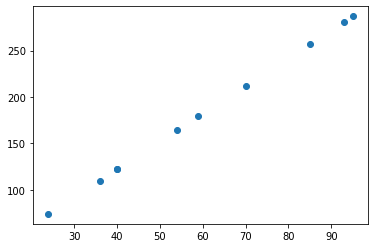

In [ ]:
#Example plot
import numpy as np
import matplotlib.pyplot as plt 

xs = np.random.randint(100, size=10)
ys = xs*3 + 2
plt.scatter(xs,ys)

**The assumption doesn't seem to hold.**

***Logistic Regression***

How to use logistic regression functions from sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html 


```
>>> from sklearn.datasets import load_iris
>>> from sklearn.linear_model import LogisticRegression
>>> X, y = load_iris(return_X_y=True)
>>> clf = LogisticRegression(random_state=0).fit(X, y)
# .coef_ and .intercept_ the same as LinearRegression
```



### **d) Set up logistic regression model for cell type classification of GABAergic cells and report genes with largest coefficients.** 

With logistic regression we can model a categorical variable (e.g. cell type) as a continuous value (i.e. the probability of being in the category). Here we will model the contribution of each gene to the probability of a cell being in the GABAergic cell type or not. 





In order to determine which genes contribute to designating that a cell is in that cell type or not, we will subset the count matrix (X) for only female cells, and then perform logistic regression. Y will be binary, 0 or 1, representing whether a cell is GABAergic or not.

Thus the logistic regression model models the probability that Y = 1, that Y is of the GABAergic cell type, not from the remaining cells.



**Fit separate, logistic regression models for each of the 2000 genes, and report the top 10 genes with the highest beta coefficients i.e. the genes where changes in their expression highly contribute to the probability of the cell being in the desired category**

In [ ]:
#Set up model and extract beta
from sklearn.linear_model import LogisticRegression




***Partial Correlations***

Partial correlation is a measure of association between two variables, after controlling for the effect of a third random variable. As a general example, one may want to measure correlation between age and memory performance, but may want to remove the effect of education level from this correlation.

Partial correlation can be framed as correlation of the residuals from two regression problems: (1) X ~ Z and (2) Y ~ Z. The partial correlation between X and Y is then the pearson correlation of the residuals of (1) and (2).

Below we will go through the steps of calculating the partial correlation for the gene pair in parts a-d.

### **e) Find linear regression fits of each gene's expression profile for the gene pair given below, against the sex of cells. Report the coefficient and intercept for each model.**

Fit linear regression models of (1) gene 1 expression against sex (binary 0 or 1 for Male or Female) and (2) gene 2 expression against sex (binary 0 or 1 for Male or Female). This is done across all cells (the count matrix with both sexes and all cell types). Convert the 'M' and 'F' to binary values, (0 or 1), for the regression models.

**Print the coefficient and intercept for each model as well as the original pearson correlation of the genes, Atp5g3 and mt-Atp8 (which we will use for comparison). You can use [scipy.stats.pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)**

In [ ]:
#Set up regression models
from scipy import stats

#Example of scipy.stats.pearsonr
#r = stats.pearsonr([1, 2, 3, 4, 5], [10, 9, 2.5, 6, 4])[0]
#print(r)

gene1 = 'mt-Atp8'
gene2 = 'Atp5g3'



### **f) Report the residuals from each regression fit.**
Residuals are defined as predicted - observed values, for each model.

**Report the first 5 residual values for each model.**

In [ ]:
#Get residuals


### **g) Now find and report the partial correlation between the genes in the pair. This is the Pearson correlation coefficient, as defined in b, between the residuals.**

In [ ]:
#Get correlation
